<img src="http://oproject.org/tiki-download_file.php?fileId=8&display&x=450&y=128">
<img src="http://oproject.org/tiki-download_file.php?fileId=25&display&x=452&y=161">
<img src="http://gfif.udea.edu.co/root/tmva/img/tmva_logo.gif">
## Required header files

In [1]:
#include <cstdlib>
#include <iostream>
#include <map>
#include <string>

#include "TChain.h"
#include "TFile.h"
#include "TTree.h"
#include "TString.h"
#include "TObjString.h"
#include "TSystem.h"
#include "TROOT.h"

#include "TMVA/Factory.h"
#include "TMVA/Tools.h"
#include "TMVA/DataLoader.h"
#include "TMVA/MethodPyAdaBoost.h"
#include "TMVA/MethodPyGTB.h"
#include "TMVA/MethodPyRandomForest.h"

## Declare Factory and DataLoader

In [2]:
TMVA::Tools::Instance();

TString outfileName( "PyMVAOutput.root" );
TFile* outputFile = TFile::Open( outfileName, "RECREATE" );

TMVA::Factory *factory = new TMVA::Factory( "TMVAClassification", outputFile,
                                               "!V:ROC:Correlations:!Silent:Color:!DrawProgressBar:AnalysisType=Classification" );
   
TMVA::DataLoader *loader=new TMVA::DataLoader("mymc-dataset");
TFile *input = TFile::Open( "MyMCdataset.root");

--- Factory                  : You are running ROOT Version: 6.05/03, Sep 14, 2015
--- Factory                  : 
--- Factory                  : _/_/_/_/_/ _|      _|  _|      _|    _|_|   
--- Factory                  :    _/      _|_|  _|_|  _|      _|  _|    _| 
--- Factory                  :   _/       _|  _|  _|  _|      _|  _|_|_|_| 
--- Factory                  :  _/        _|      _|    _|  _|    _|    _| 
--- Factory                  : _/         _|      _|      _|      _|    _| 
--- Factory                  : 
--- Factory                  : ___________TMVA Version 5.0.0 alpha, Oct 30, 2015
--- Factory                  : 


## Adding variables to DataLoader

In [3]:
loader->AddVariable( "var0", 'F' );
loader->AddVariable( "var1", 'F' );
loader->AddVariable( "var2", 'F' );
loader->AddVariable( "var3 := var0-var1", 'F' );
loader->AddVariable( "var4 := var0*var2", 'F' );
loader->AddVariable( "var5 := var1+var2", 'F' );

In [4]:
std::cout << "--- TMVAClassification       : Using input file: " << input->GetName() << std::endl;
   
// --- Register the training and test trees
TTree *tsignal     = (TTree*)input->Get("MyMCSig");
TTree *tbackground = (TTree*)input->Get("MyMCBkg");
   
Double_t signalWeight     = 1.0;
Double_t backgroundWeight = 1.0;
   
loader->AddSignalTree    ( tsignal,     signalWeight     );
loader->AddBackgroundTree( tbackground, backgroundWeight );   
    
TCut mycuts = ""; 
TCut mycutb = ""; 

loader->fSignalWeight=signalWeight;
loader->fBackgroundWeight=backgroundWeight;
loader->fTreeS=tsignal;
loader->fTreeB=tbackground;
loader->PrepareTrainingAndTestTree( mycuts, mycutb,
                                   "nTrain_Signal=3000:nTrain_Background=3000:nTest_Signal=1449:nTest_Background=1449:SplitMode=Random:NormMode=NumEvents:!V" );

--- TMVAClassification       : Using input file: MyMCdataset.root
--- DataSetInfo              : Dataset[mymc-dataset] : Added class "Signal"	 with internal class number 0
--- mymc-dataset             : Add Tree MyMCSig of type Signal with 5449 events
--- DataSetInfo              : Dataset[mymc-dataset] : Added class "Background"	 with internal class number 1
--- mymc-dataset             : Add Tree MyMCBkg of type Background with 5449 events
--- mymc-dataset             : Preparing trees for training and testing...


## Booking Methods
Available Booking methods with options for PyMVA are

PyRandomForest http://oproject.org/tiki-index.php?page=PyMVA#PyRFBooking

PyGTB (Gradient Trees Boosted) http://oproject.org/tiki-index.php?page=PyMVA#PyGTBBooking

PyAdaBoost (Adaptative Boosting) http://oproject.org/tiki-index.php?page=PyMVA#PyAdaBoostBooking

In [5]:
//Random Forest
factory->BookMethod(loader,TMVA::Types::kPyRandomForest, "PyRandomForest","!V:NEstimators=10:Criterion=gini:MaxFeatures=auto:MaxDepth=6:MinSamplesLeaf=3:MinWeightFractionLeaf=0:Bootstrap=kTRUE" );

//Gradient Trees Boosted
factory->BookMethod(loader,TMVA::Types::kPyGTB, "PyGTB","!V:NEstimators=10:Loss=deviance:LearningRate=0.1:Subsample=1:MaxDepth=3:MaxFeatures='auto'" );
   
//Adaptative Boost
factory->BookMethod(loader,TMVA::Types::kPyAdaBoost, "PyAdaBoost","!V:NEstimators=10:LearningRate=1.0:Algorithm=SAMME.R" );

--- Factory                  : Booking method: PyRandomForest DataSet Name: mymc-dataset
--- DataSetFactory           : Dataset[mymc-dataset] : Splitmode is: "RANDOM" the mixmode is: "SAMEASSPLITMODE"
--- DataSetFactory           : Dataset[mymc-dataset] : Create training and testing trees -- looping over class "Signal" ...
--- DataSetFactory           : Dataset[mymc-dataset] : Weight expression for class 'Signal': ""
--- DataSetFactory           : Dataset[mymc-dataset] : Create training and testing trees -- looping over class "Background" ...
--- DataSetFactory           : Dataset[mymc-dataset] : Weight expression for class 'Background': ""
--- DataSetFactory           : Dataset[mymc-dataset] : Number of events in input trees (after possible flattening of arrays):
--- DataSetFactory           : Dataset[mymc-dataset] :     Signal          -- number of events       : 5449   / sum of weights: 5449 
--- DataSetFactory           : Dataset[mymc-dataset] :     Background      -- number of eve

## Training the Methods

In [6]:
 factory->TrainAllMethods();

--- Factory                  :  
--- Factory                  : Train all methods for Classification ...
--- Factory                  : 
--- Factory                  : current transformation string: 'I'
--- Factory                  : Dataset[mymc-dataset] : Create Transformation "I" with events from all classes.
--- Id                       : Transformation, Variable selection : 
--- Id                       : Input : variable 'var0' (index=0).   <---> Output : variable 'var0' (index=0).
--- Id                       : Input : variable 'var1' (index=1).   <---> Output : variable 'var1' (index=1).
--- Id                       : Input : variable 'var2' (index=2).   <---> Output : variable 'var2' (index=2).
--- Id                       : Input : variable 'var3' (index=3).   <---> Output : variable 'var3' (index=3).
--- Id                       : Input : variable 'var4' (index=4).   <---> Output : variable 'var4' (index=4).
--- Id                       : Input : variable 'var5' (index=5).  

## Testing and Evaluating the data

In [7]:
factory->TestAllMethods();
factory->EvaluateAllMethods();

--- Factory                  : Test all methods...
--- Factory                  : Test method: PyRandomForest for Classification performance
--- PyRandomForest           : Dataset[mymc-dataset] : Evaluation of PyRandomForest on testing sample (2898 events)
--- PyRandomForest           : 
--- PyRandomForest           : --- Loading State File From:weights/PyRFModel.PyData
--- PyRandomForest           : 
--- PyRandomForest           : Dataset[mymc-dataset] : Elapsed time for evaluation of 2898 events: 3.85 sec       
--- Factory                  : Test method: PyGTB for Classification performance
--- PyGTB                    : Dataset[mymc-dataset] : Evaluation of PyGTB on testing sample (2898 events)
--- PyGTB                    : 
--- PyGTB                    : --- Loading State File From:weights/PyGTBModel.PyData
--- PyGTB                    : 
--- PyGTB                    : Dataset[mymc-dataset] : Elapsed time for evaluation of 2898 events: 0.382 sec       
--- Factory                

In [8]:
// Save the output
outputFile->Close();

std::cout << "==> Wrote root file: " << outputFile->GetName() << std::endl;
std::cout << "==> TMVAClassification is done!" << std::endl;

delete factory;
delete loader;

==> Wrote root file: PyMVAOutput.root
==> TMVAClassification is done!


## Ploting ROC Curve

--- Found 3 classifier types
--- Found 1 instance(s) of the method Method_PyRandomForest
--- Found 1 instance(s) of the method Method_PyGTB
--- Found 1 instance(s) of the method Method_PyAdaBoost
--- Found 3 classifier types
--- Found 1 instance(s) of the method Method_PyRandomForest
--- Found 1 instance(s) of the method Method_PyGTB
--- Found 1 instance(s) of the method Method_PyAdaBoost


TColor::TColor:0: RuntimeWarning: color 1367 already defined
Info in <TCanvas::Print>: eps file plots/rejBvsS.eps has been created


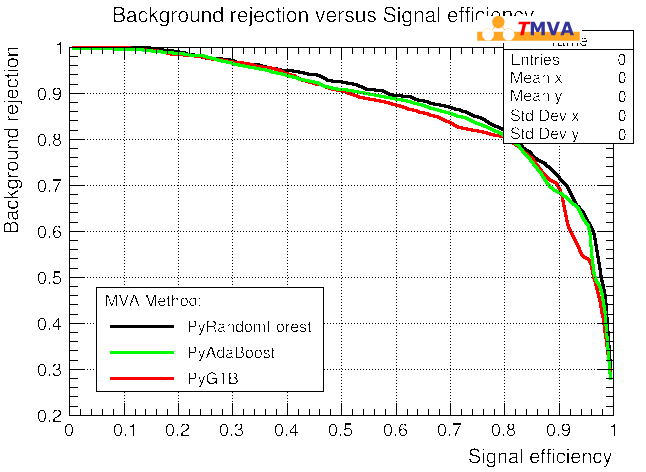

In [9]:
TFile *file=TFile::Open("PyMVAOutput.root");
gDirectory->cd("mymc-dataset");

TMVA::plot_efficiencies(file,  2,gDirectory);
c->Draw();